In [67]:
%config InlineBackend.figure_formats = ['retina']
import numpy as np
import pylab as pl
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from sklearn import svm
from sklearn.utils import shuffle
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from keras import optimizers

# Load data

In [2]:
names = ['Ant', 'Grapes']

In [3]:
X_ant = np.load('./data/G_21_ant.npy')
X_grapes = np.load('./data/G_21_grapes.npy')

In [4]:
X_test = np.load('./data/test_images.npy')
y_test = np.load('./data/test_labels.npy').astype(int)

# Creates labels for ant and grapes

The labels defined in the test set are ant = label $0$ and grapes = label $1$, so we will use the same labelling for the train set.

In [5]:
y_ant = np.zeros((X_ant.shape[0],))
y_grapes = np.ones((X_grapes.shape[0],))

# Merge the data into one matrix

In [6]:
X_train = np.concatenate((X_ant, X_grapes), axis=0)

In [7]:
y_train = np.concatenate((y_ant, y_grapes), axis=0).astype(int)

We want to shuffle the data to be sure that the data set is representative of both classes.

In [8]:
X_train, y_train = shuffle(X_train, y_train, random_state=0)
X_test, y_test = shuffle(X_test, y_test, random_state=0)

Standardisation of the data is necessary for the PCA. We use the same transformation on X_train and on X_test.

In [9]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# PCA for dimensionality reduction

We want to keep the first two principal components of the PCA in order to be able to represent the data in 2D, which may give us clues about rather the data is linearly separable or not.

In [10]:
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X_train)

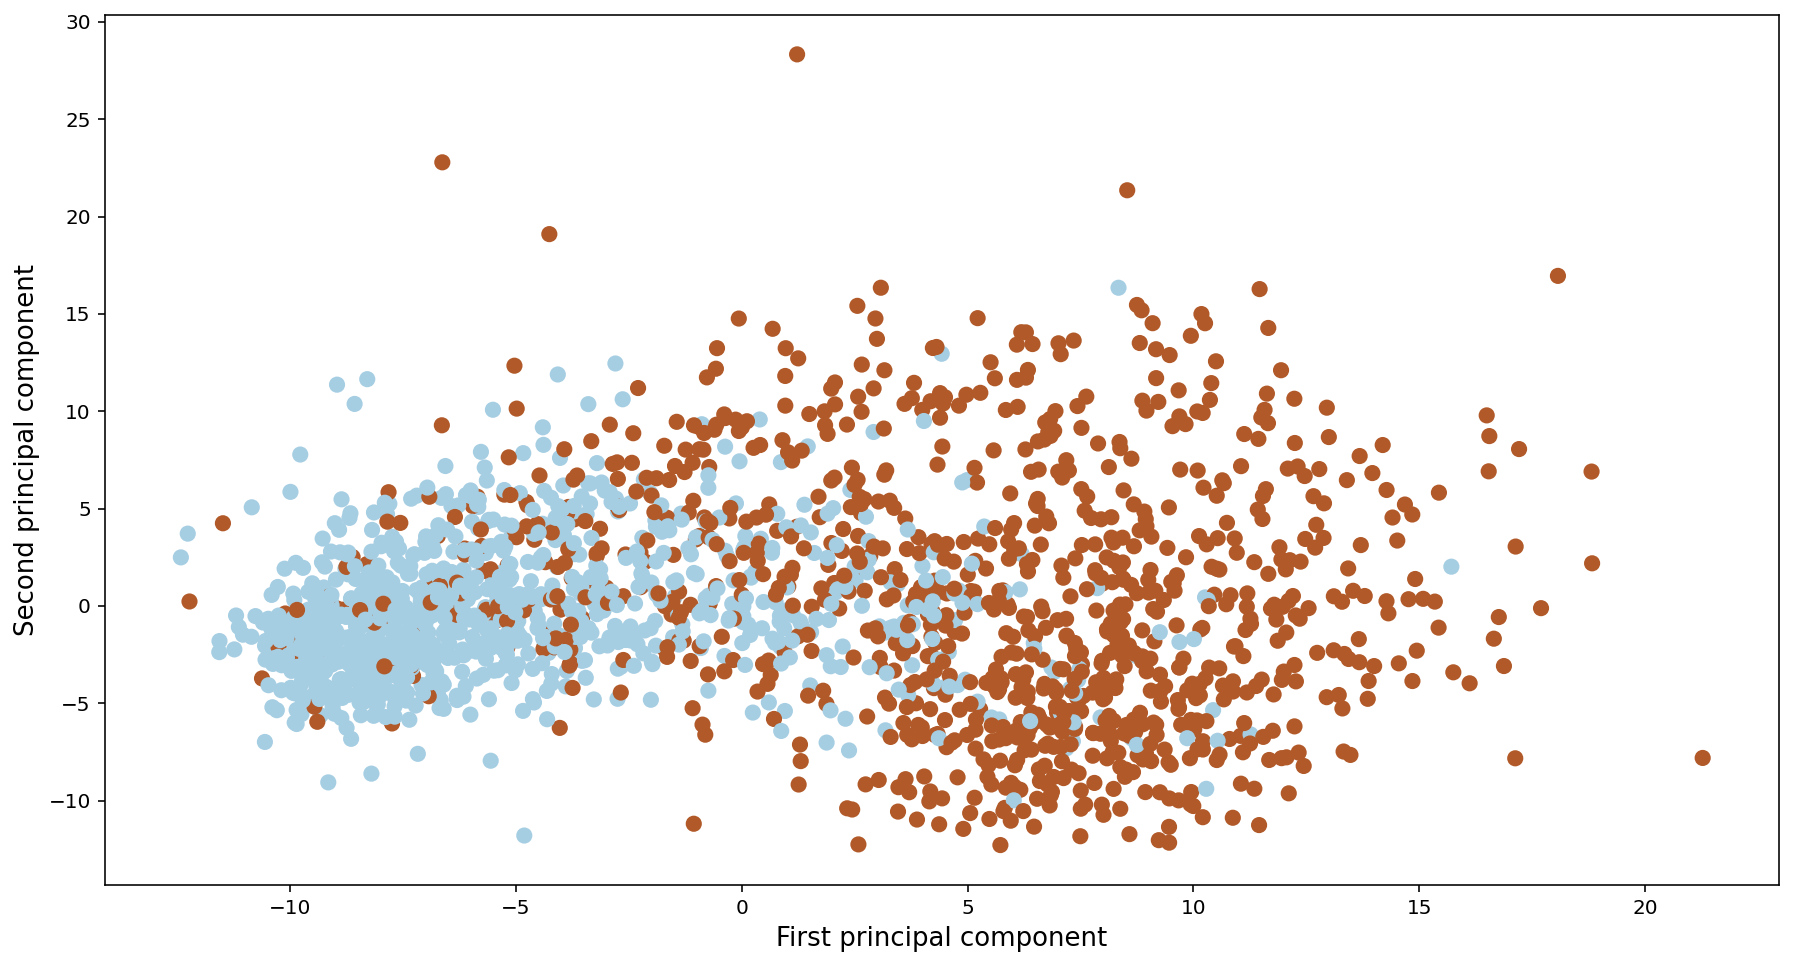

In [11]:
plt.figure(figsize=(15,8))
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=y_train, s=50, cmap=plt.cm.Paired)
plt.xlabel('First principal component', size=13)
plt.ylabel('Second principal component', size=13)
plt.show()

From the plot, we can see that the data is not linearly separable at all. We will therefore only use non-linear classifiers.

First, we will try to use SVM with a Gaussian kernel. The two other algorithms that we will test to see if we get better results are decision trees (and Random Forest) and a neural network.

# SVM with a Gaussian kernel

We use cross-validation to determine the best values for the hyperparameters.

In [65]:
%%time
clf_rbf = GridSearchCV(SVC(kernel='rbf'), param_grid={'C':np.logspace(-1,1,10), 'gamma':['scale', 'auto']})
clf_rbf.fit(X_train, y_train)
print(clf_rbf.best_params_)

{'C': 3.593813663804626, 'gamma': 'scale'}
CPU times: user 2min 15s, sys: 403 ms, total: 2min 16s
Wall time: 2min 16s


In [101]:
print('Accuracy on train set:', clf_rbf.score(X_train, y_train))
print('Accuracy on test set:', clf_rbf.score(X_test, y_test))

Accuracy on train set: 0.986
Accuracy on test set: 0.863


This first model gives quite good results on the test set, but it can potentially be increased by using a different classification model.

# Decision Tree

In [92]:
%%time
d_tree_params = {'criterion' : ['gini', 'entropy'], 'splitter' : ['best', 'random'], 'min_samples_leaf' : np.arange(40,50)}
dec_tree = GridSearchCV(DecisionTreeClassifier(),d_tree_params)
dec_tree.fit(X_train,y_train)
print(dec_tree.best_params_)

{'criterion': 'entropy', 'min_samples_leaf': 39, 'splitter': 'random'}
CPU times: user 1min 29s, sys: 928 ms, total: 1min 30s
Wall time: 1min 33s


In [94]:
print('Accuracy on train set:', dec_tree.score(X_train, y_train))
print('Accuracy on test set:', dec_tree.score(X_test, y_test))

Accuracy on train set: 0.849
Accuracy on test set: 0.786


# Random Forest Classifier

In [95]:
rfc = RandomForestClassifier(criterion='entropy', min_samples_leaf=10, max_samples=0.5, random_state=0)
rfc.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_samples=0.5,
                       min_samples_leaf=10, random_state=0)

In [96]:
print('Accuracy on train set:', rfc.score(X_train, y_train))
print('Accuracy on test set:', rfc.score(X_test, y_test))

Accuracy on train set: 0.9015
Accuracy on test set: 0.728


In [99]:
%%time
rf_params = {'criterion' : ['gini', 'entropy'], 'min_samples_leaf' : np.arange(5,20)}
rfc_cv = GridSearchCV(RandomForestClassifier(),rf_params)
rfc_cv.fit(X_train,y_train)
print(rfc_cv.best_params_)

{'criterion': 'entropy', 'min_samples_leaf': 9}
CPU times: user 6min 7s, sys: 2.92 s, total: 6min 10s
Wall time: 6min 20s


In [100]:
print('Accuracy on train set:', rfc_cv.score(X_train, y_train))
print('Accuracy on test set:', rfc_cv.score(X_test, y_test))

Accuracy on train set: 0.932
Accuracy on test set: 0.72


# Neural network

For the architecture of the neural network, we have 784 values in input and only 2 values in output. We use the sigmoid activation function for the output layer because we want a value between 0 and 1, that will represent the probability of being either of class 0 or of class 1.

Then, we have tested different architecture (with more hidden layers, with different number of neurons per layer), and we have found that the following architecture gives us the best results on average.

In [29]:
y_train_NN = to_categorical(y_train)
y_test_NN = to_categorical(y_test)

In [30]:
model = Sequential()
input_shape = 784
layer_1_shape = 300
output_shape = 2
model.add(Dense(layer_1_shape, activation='relu', input_dim=input_shape))
model.add(Dense(output_shape, activation='sigmoid'))

In [31]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [32]:
%%time
epochs=10
history = model.fit(X_train, y_train_NN, epochs=epochs, batch_size=10, validation_data=(X_test, y_test_NN))

Epoch 1/10
200/200 [==============================] - 2s 7ms/step - loss: 0.6025 - accuracy: 0.8022 - val_loss: 0.4402 - val_accuracy: 0.8320
Epoch 2/10
200/200 [==============================] - 1s 4ms/step - loss: 0.1532 - accuracy: 0.9357 - val_loss: 0.4450 - val_accuracy: 0.8420
Epoch 3/10
200/200 [==============================] - 1s 3ms/step - loss: 0.0765 - accuracy: 0.9698 - val_loss: 0.4630 - val_accuracy: 0.8450
Epoch 4/10
200/200 [==============================] - 1s 3ms/step - loss: 0.0307 - accuracy: 0.9927 - val_loss: 0.4811 - val_accuracy: 0.8510
Epoch 5/10
200/200 [==============================] - 1s 3ms/step - loss: 0.0136 - accuracy: 0.9974 - val_loss: 0.4824 - val_accuracy: 0.8530
Epoch 6/10
200/200 [==============================] - 1s 3ms/step - loss: 0.0055 - accuracy: 1.0000 - val_loss: 0.5201 - val_accuracy: 0.8510
Epoch 7/10
200/200 [==============================] - 1s 3ms/step - loss: 0.0023 - accuracy: 1.0000 - val_loss: 0.5262 - val_accuracy: 0.8490
Epoch 

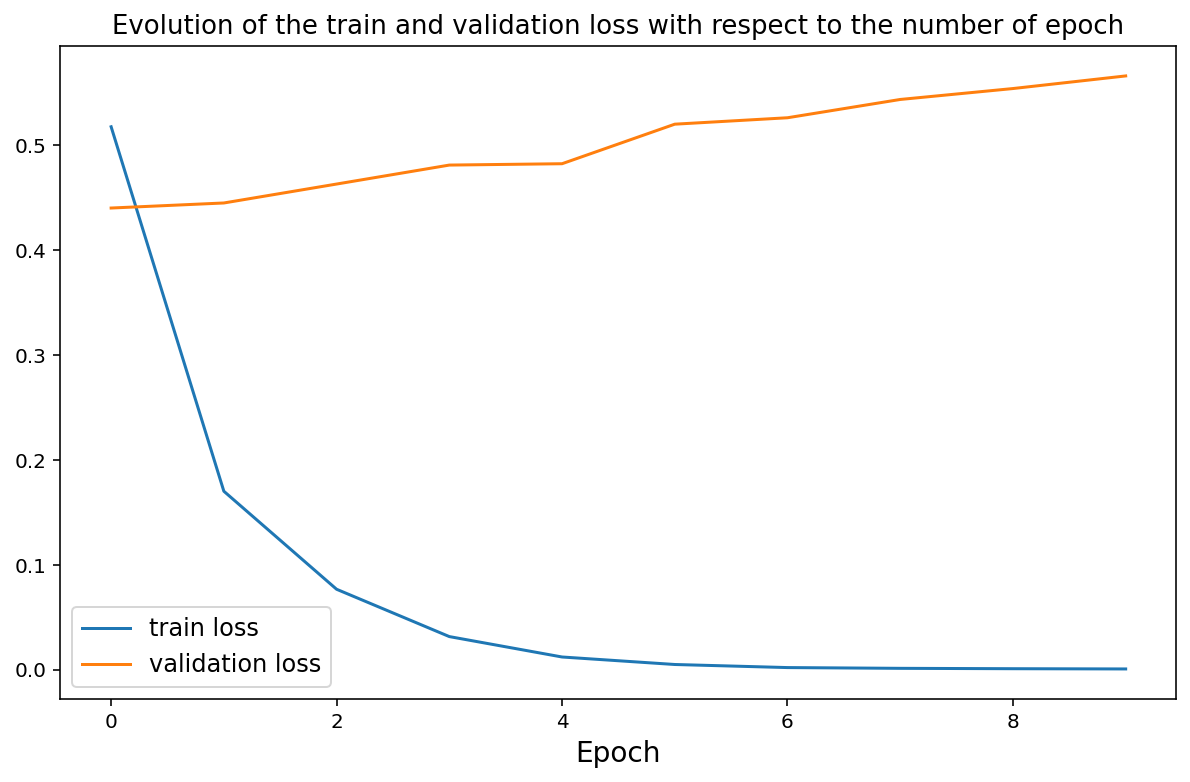

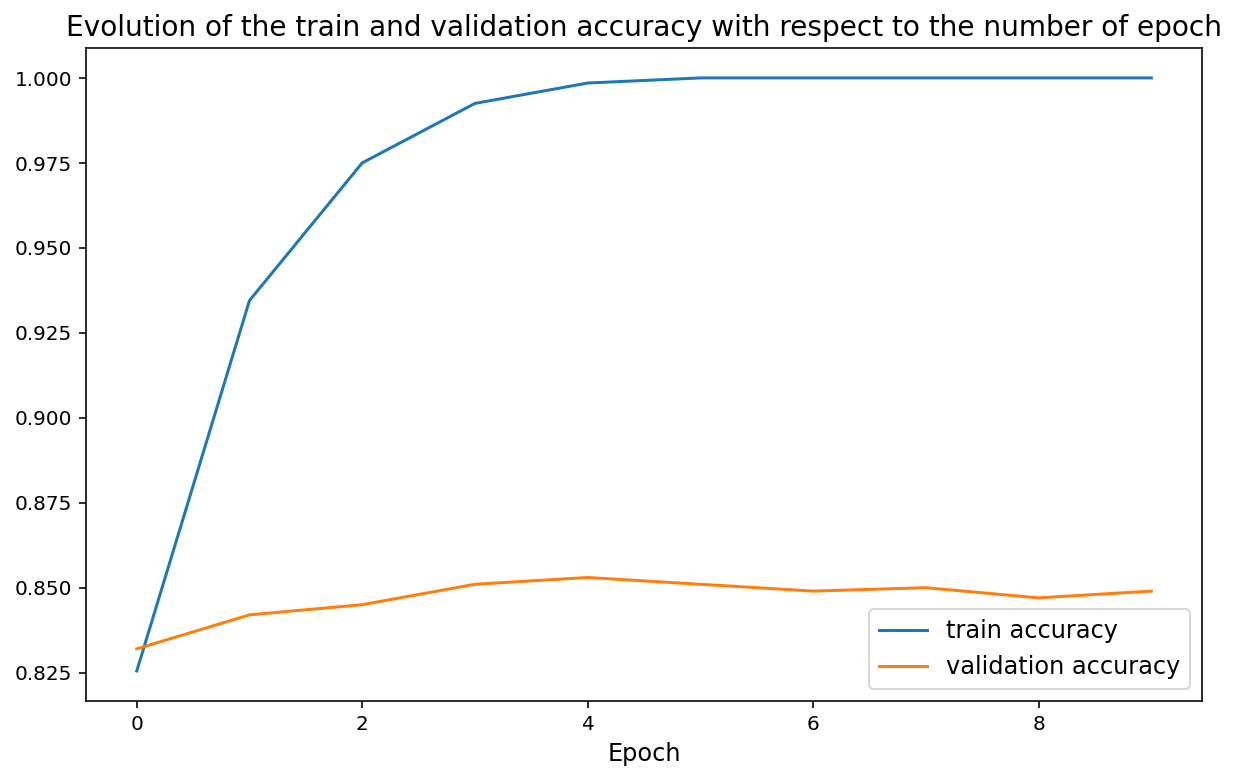

In [33]:
plt.figure(figsize=(10,6))

plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.xlabel('Epoch', size=14)
plt.title('Evolution of the train and validation loss with respect to the number of epoch', size=13)

plt.legend(fontsize=12)
plt.show()

plt.figure(figsize=(10,6))

plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.xlabel('Epoch', size=12)
plt.title('Evolution of the train and validation accuracy with respect to the number of epoch', size=14)

plt.legend(fontsize=12)
plt.show()

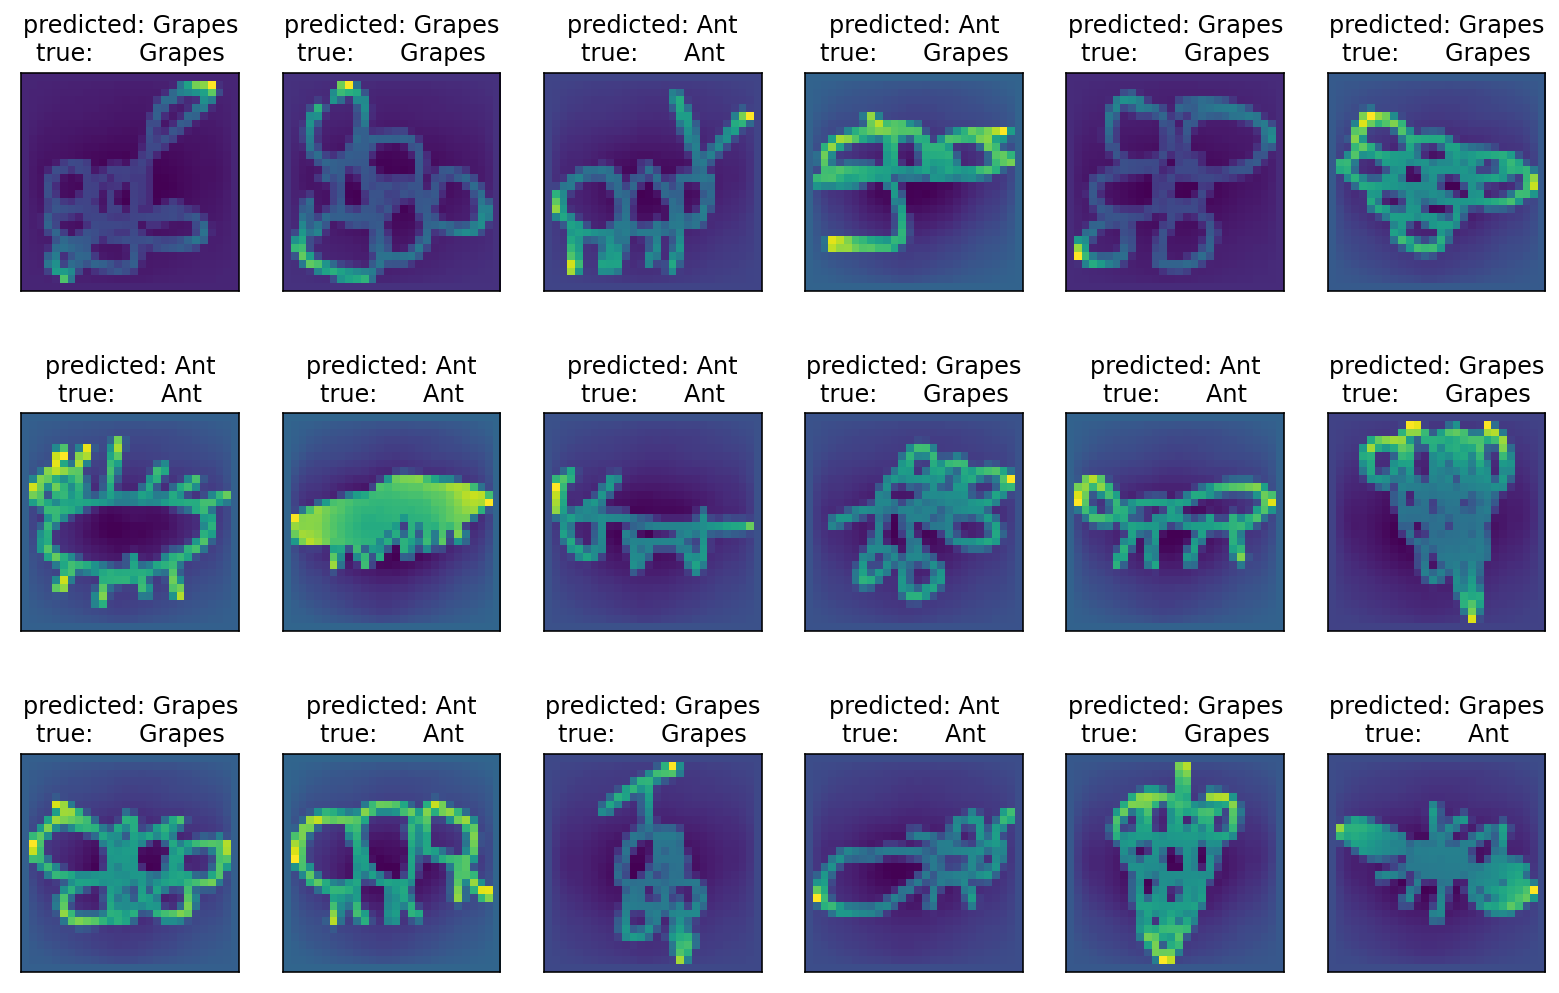

In [46]:
def plot_gallery(images, titles, n_row=3, n_col=6):
    """Helper function to plot a gallery of portraits"""
    pl.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    pl.subplots_adjust(bottom=0, left=.01, right=.99, top=.90,
                       hspace=.35)
    for i in range(n_row * n_col):
        pl.subplot(n_row, n_col, i + 1)
        pl.imshow(images[i].reshape(28,28,))
        pl.title(titles[i], size=12)
        pl.xticks(())
        pl.yticks(())


def title(y_pred, y_test, names):
    pred_name = names[int(y_pred)].rsplit(' ', 1)[-1]
    true_name = names[int(y_test)].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

y_pred_NN = np.argmax(model.predict(X_test), axis=1)
y_pred_rbf = clf_rbf.predict(X_test)
y_pred_rfc = rfc.predict(X_test)
prediction_titles = [title(y_pred_rbf[i], y_test[i], names)
                     for i in range(y_pred.shape[0])]

plot_gallery(X_test, prediction_titles)
pl.show()

# Conclusions